## RLDMUU 2025
#### Bayesian Reinforcement Learning
jakub.tluczek@unine.ch

In today's lab we are going to take a look at the Bayesian flavor of the Q-Learning. Generally speaking, Bayesian RL takes advantages of Bayesian inference, when dealing with information update. Here, the Q values are sampled from the distribution associated with each state-action pair, while the updates are being performed on conjugate priors. In this tutorial we will assume that Q-values are gaussian distributed with unit variance. *Modus operandi* is very similar to lab 3 and Thompson sampling for gaussian bandits.

Recall, that updating the conjugate prior in gaussian thompson sampling for multi armed bandits is done by following update rules:

$$ \hat{\mu}_k' = \mathbb{E}(\hat{\mu}_k' | r) = \frac{\hat{\sigma}_k^2 r + \sigma_k^2 \hat{\mu}_k}{\hat{\sigma}_k^2 + \sigma_k^2} $$ 
$$ \hat{\sigma}_k' = \sqrt{\text{Var}(\hat{\mu}_k | r)} = \sqrt{\frac{\hat{\sigma}_k^2 \sigma_k^2}{\hat{\sigma}_k^2 + \sigma_k^2}}$$

In this setting however, we need to substitute the reward term for bandits with the temporal difference target, with additional observation noise, sampled from separate distribution, which in our case will also be gaussian:

$$ r + \gamma \max_a Q(s', a) + \epsilon$$
$$ \epsilon \sim \mathcal{N}(0, \sigma^2_{\epsilon})$$

To sum up, the procedure for single Bayesian Q Learning update is as follows:

- sample the values from conjugate prior distributions for different Q-values at the current state
- choose the action maximizing the samples
- act on the environment, observe the next state and reward, and use it to update the prior parameters, $\hat{\mu}'_k$ and $\hat{\sigma}'_k$


When calculating the $\max_a Q(s', a)$ term, you can just use the mean values of conjugate priors, thus avoiding sampling from the posterior and potentially destabilizing the training.

In [1]:
import gymnasium as gym 
import numpy as np

In [4]:
class BayesianQLearning:
    def __init__(self, states, actions, mu_zero=0., gamma=.95, noise_std=1.):
        self.states = states
        self.actions = actions
        self.gamma = gamma

        self.prior_mu = np.full((states, actions), mu_zero)
        self.prior_std = np.full((states, actions), 1.)

        self.noise_prior_std = noise_std

    def act(self, state):
        state_samples = np.random.normal(self.prior_mu[state], self.prior_std[state])
        return np.argmax(state_samples)

    def update_priors(self, state, action, reward, next_state, terminated, truncated):
        # TODO : Calculate the target value used for update
        target = reward + (1 - terminated) * self.gamma * np.max(self.prior_mu[next_state]) + np.random.normal(0, self.noise_prior_std)
        # Don't forget about the observation noise!
        true_std = 1.
        # TODO: Update prior using Bayesian rule
        self.prior_mu[state, action] = (self.prior_std[state, action]**2 * target + true_std**2 * self.prior_mu[state, action]) / (self.prior_std[state, action]**2 + true_std**2)
        self.prior_std[state, action] = np.sqrt((self.prior_std[state, action] ** 2 * true_std**2)/(self.prior_std[state, action] ** 2 + true_std**2))

Run the experiments with different values of parameters and log the results. Feel free to use the results from Lab 6 as a baseline

In [8]:
env = gym.make('FrozenLake-v1', is_slippery=False)

N_EPISODES = 10000
N_ITER = 1000

MU_ZERO = 0.
GAMMA = 0.95
NOISE_STD = 1.

state, info = env.reset()
done = False

algo = BayesianQLearning(states=env.observation_space.n, actions=env.action_space.n, mu_zero=MU_ZERO, gamma=GAMMA, noise_std=NOISE_STD)

nsteps = np.ones(N_EPISODES) * N_ITER
mean_episode_rewards = np.zeros(N_EPISODES)

for e in range(N_EPISODES):
    for i in range(N_ITER):
        action = algo.act(state)

        next_state, reward, done, truncated, info = env.step(action)

        algo.update_priors(state, action, reward, next_state, done, truncated)

        if done or truncated:
            state, info = env.reset()
            done = False 
            truncated = False
            if reward == 1:
                nsteps[e] = i
                mean_episode_rewards[e] = 1 / i
            break 

        state = next_state

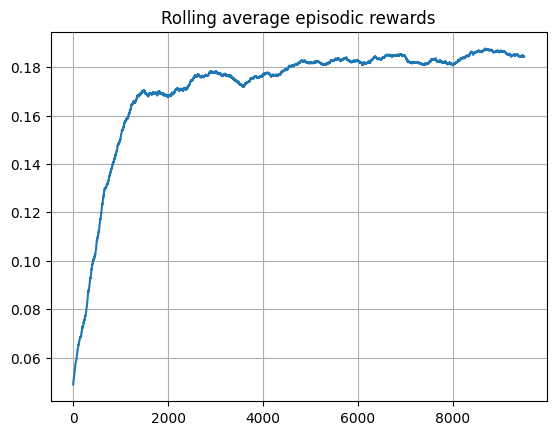

In [9]:
from matplotlib import pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(mean_episode_rewards, 500))
plt.title("Rolling average episodic rewards")
plt.grid()

Source and interactive visualizations: [Bayesian perspective on Q Learning](https://brandinho.github.io/bayesian-perspective-q-learning/)